In [1]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("../iGMRF.jl");
include("../dataGen.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [2]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;

In [3]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

In [4]:
grid_target[:, :, 2]

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [5]:
grid_target[:, :, 3]

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [6]:
nobs = 100;
data = generateData(grid_target, nobs);

In [7]:
data

9-element Vector{Vector{Float64}}:
 [12.240682784141626, 9.621417291612469, 9.754494171763968, 12.271969563649202, 9.010088679836304, 10.37854664173395, 9.953170110473183, 9.445009003021907, 9.742009013625772, 9.570691209584776  …  10.518164573659204, 9.930013357326203, 10.282186137930879, 12.850825190676971, 11.539774471964721, 9.408520146607469, 10.911372616309231, 8.729801983142732, 8.72967686719628, 11.836572621374048]
 [11.273789202970812, 8.631556095806973, 13.163945842014405, 11.344148819126897, 9.546754812779685, 10.288636123061432, 8.323184365488917, 11.519918761572495, 10.633947875839283, 9.701374233994922  …  11.842867771041316, 10.125426468920546, 10.559271503126375, 11.915013128851271, 11.83414170304287, 10.090763718674232, 9.618733796527398, 11.037493453323496, 12.569207209872223, 10.34323657298342]
 [10.84714848560555, 10.09386643901673, 11.374159042999196, 10.054626371286963, 11.072357692987763, 9.28577559547066, 11.744733738776487, 9.621447951938798, 9.092795759344487,

# Modèle 

In [24]:
include("malaWG.jl");

niter = 10000;
h = 0.0021;
θ₀ = vcat([50], fill(0, m))
F = iGMRF(m₁, m₂, 0)
nchains = 1;

κᵤ, μ = malaWG(niter, h, θ₀, Y=data, F=F, nchains=nchains);

warming_size = Int(0.2 * niter)

κᵤSampling = κᵤ[warming_size:end, :];
μSampling = μ[warming_size:end, :, 1];

κ̂ᵤ = mean(κᵤSampling);
μ̂ = mean(μSampling.value, dims=1);

In [25]:
changerate(μSampling).value

10×1×1 Array{Float64, 3}:
[:, :, 1] =
 0.591
 0.591
 0.591
 0.591
 0.591
 0.591
 0.591
 0.591
 0.591
 0.591

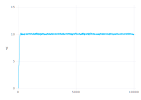

In [26]:
plot(y=μ.value[:, 1, 1], Geom.line)

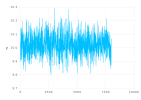

In [27]:
plot(y=μSampling.value[:, 1, 1], Geom.line)

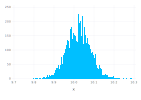

In [28]:
plot(x=μSampling.value[:, 1, 1], Geom.histogram)

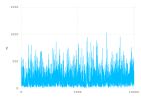

In [29]:
plot(y=κᵤ, Geom.line)

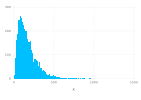

In [30]:
plot(x=κᵤSampling, Geom.histogram)

In [31]:
κ̂ᵤ

168.61004102722063

In [32]:
summarystats(μSampling)

      Mean        SD        Naive SE       MCSE        ESS   
μ1 10.023239 0.061018268 0.00068216234 0.0024474348 621.58067
μ2 10.014523 0.055753672 0.00062330605 0.0023470774 564.27673
μ3  9.976251 0.062870795 0.00070287292 0.0026794862 550.54759
μ4 10.040868 0.062877552 0.00070294847 0.0028860887 474.64827
μ5  9.992550 0.050734627 0.00056719492 0.0021407344 561.67276
μ6  9.982866 0.057433951 0.00064209097 0.0027216145 445.33227
μ7  9.985778 0.063901069 0.00071439102 0.0027391491 544.23303
μ8  9.964168 0.058917850 0.00065868043 0.0027029628 475.13131
μ9  9.976756 0.063060410 0.00070499276 0.0030231860 435.09475



In [33]:
reshape(μ̂, m₁, m₂)'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 10.0232   10.0145   9.97625
 10.0409    9.99255  9.98287
  9.98578   9.96417  9.97676

In [34]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

Distance entre les deux matrices

In [35]:
norm(reshape(μ̂, m₁, m₂)' .- grid_target[:, :, 1], 2) / m

0.017144224806306913

In [36]:
describe(μSampling)

Iterations = 2000:10000
Thinning interval = 1
Chains = 1
Samples per chain = 8001

Empirical Posterior Estimates:
      Mean        SD        Naive SE       MCSE        ESS   
μ1 10.023239 0.061018268 0.00068216234 0.0024474348 621.58067
μ2 10.014523 0.055753672 0.00062330605 0.0023470774 564.27673
μ3  9.976251 0.062870795 0.00070287292 0.0026794862 550.54759
μ4 10.040868 0.062877552 0.00070294847 0.0028860887 474.64827
μ5  9.992550 0.050734627 0.00056719492 0.0021407344 561.67276
μ6  9.982866 0.057433951 0.00064209097 0.0027216145 445.33227
μ7  9.985778 0.063901069 0.00071439102 0.0027391491 544.23303
μ8  9.964168 0.058917850 0.00065868043 0.0027029628 475.13131
μ9  9.976756 0.063060410 0.00070499276 0.0030231860 435.09475

Quantiles:
      2.5%     25.0%      50.0%      75.0%     97.5%  
μ1 9.9046676 9.9827289 10.0237417 10.0629894 10.143451
μ2 9.9068841 9.9780003 10.0121559 10.0512111 10.128755
μ3 9.8417013 9.9381152  9.9792264 10.0174652 10.092664
μ4 9.9242917 9.9999335 10.0361790 